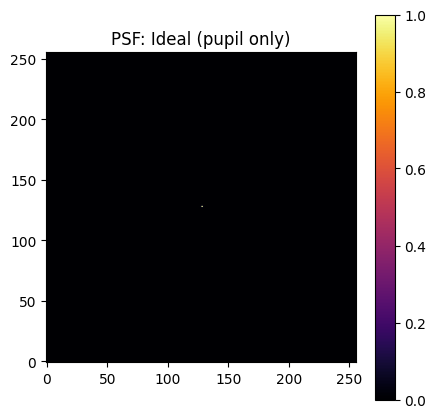

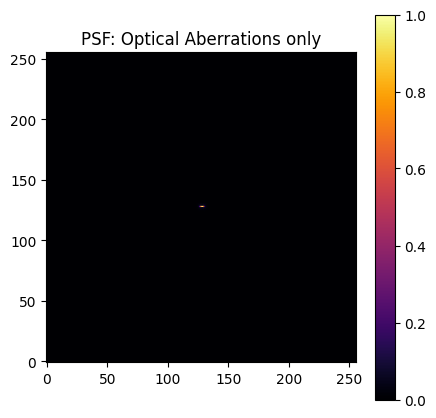

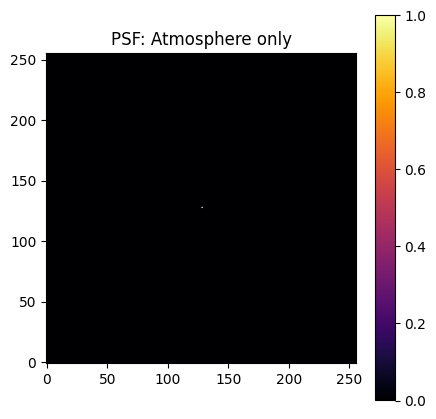

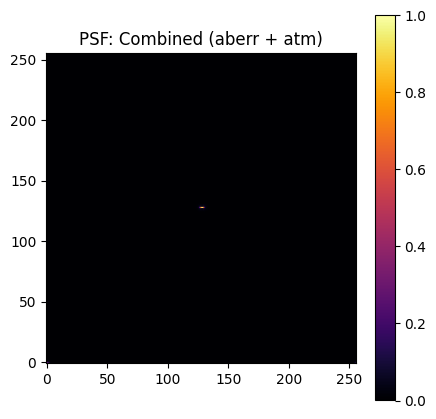

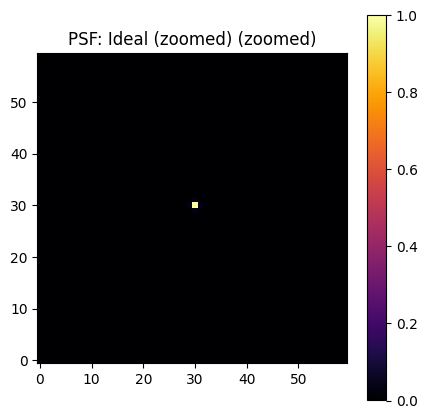

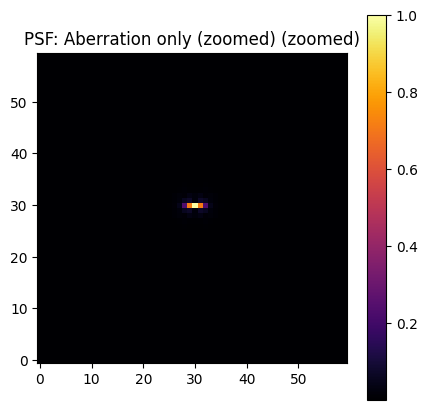

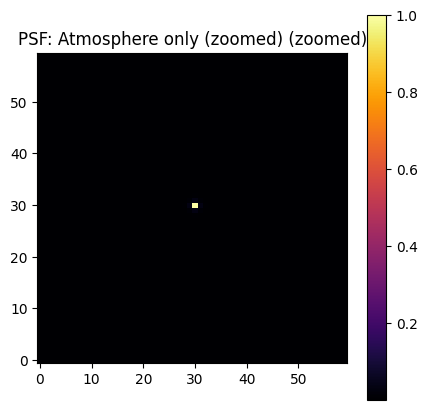

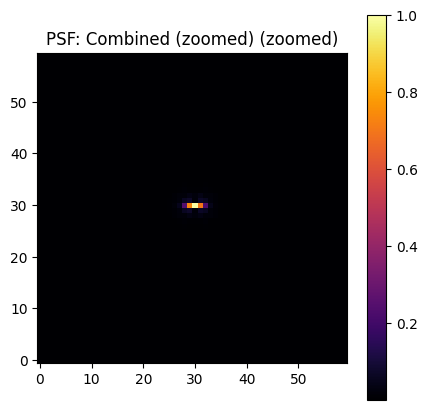

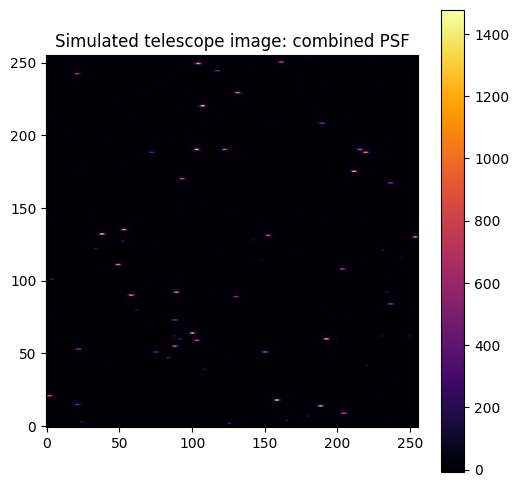

Saved combined simulated image to: sim_combined_image.fits


In [12]:
# ---------------------------
# Combine optical aberrations + atmosphere -> final PSF + simulated image
# Paste/run as a single cell
# ---------------------------
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fftshift, fft2, ifft2
from scipy.signal import fftconvolve
from scipy.special import j1
from astropy.io import fits

# ---------- Parameters (tweakable) ----------
N = 256                 # grid size (pupil plane)
r0 = 0.10               # Fried parameter (m) - smaller -> worse seeing
L0 = 10.0               # outer scale (m)
wavelength = 550e-9
SA_strength = 0.5       # spherical aberration strength
A_ast = 0.2             # astigmatism strength
phase_scale_atm = 0.5   # scaling factor for atmospheric phase
star_field_size = 256   # size of synthetic star image (pixels)

# ---------- helpers: pupil and radial coords ----------
x = np.linspace(-1, 1, N)
X, Y = np.meshgrid(x, x)
R = np.sqrt(X**2 + Y**2)
pupil = (R <= 1).astype(float)

# ---------- aberration wavefront (example: spherical + astigmatism) ----------
# spherical W_sa proportional to rho^4
rho = np.where(R==0, 0, R)   # normalized radius in [-1,1]
W_sa = SA_strength * (rho**4)

# astigmatism term (cos(2θ) * rho)
theta = np.arctan2(Y, X)
W_ast = A_ast * rho * np.cos(2*theta)

# total optical aberration (in waves)
W_aberr = W_sa + W_ast

# convert to phase in radians (phi = 2π * W)
phi_aberr = 2 * np.pi * W_aberr

# ---------- atmospheric phase (Kolmogorov-like) ----------
def make_phase_screen(N=N, r0=r0, L0=L0):
    fx = np.fft.fftfreq(N, d=1.0/N)
    FX, FY = np.meshgrid(fx, fx)
    f = np.sqrt(FX**2 + FY**2)
    f[0,0] = 1e-6
    P = (f**2 + (1.0/L0)**2)**(-11/6.0)
    # random complex gaussian field with amplitude sqrt(P)
    cn = (np.random.normal(size=(N,N)) + 1j*np.random.normal(size=(N,N)))
    fourier_field = cn * np.sqrt(P)
    phase = np.real(ifft2(fftshift(fourier_field)))
    # normalize RMS = 1 then scale later
    phase = (phase - phase.mean()) / (phase.std()+1e-12)
    return phase

# create one atm phase screen and scale to desired amplitude
phase_atm_raw = make_phase_screen()
# convert normalized phase to phase in radians using chosen scale (empirical)
phi_atm = phase_scale_atm * phase_atm_raw

# ---------- compute complex pupils ----------
pupil_ideal = pupil.copy()
pupil_aberr = pupil * np.exp(1j * phi_aberr)          # only optical aberrations
pupil_atm   = pupil * np.exp(1j * phi_atm)            # only atmosphere
pupil_combined = pupil * np.exp(1j * (phi_aberr + phi_atm))  # both

# ---------- compute PSFs (FT of complex pupil) ----------
def psf_from_pupil(complex_pupil):
    amp = fftshift(fft2(complex_pupil))
    I = np.abs(amp)**2
    I = I / (I.max() + 1e-16)
    return I

psf_ideal = psf_from_pupil(pupil_ideal)
psf_aberr = psf_from_pupil(pupil_aberr)
psf_atm   = psf_from_pupil(pupil_atm)
combined_psf = psf_from_pupil(pupil_combined)

# ---------- show comparison (zoomed view function included) ----------
def show(img, title, vmin=None, vmax=None):
    plt.figure(figsize=(5,5))
    plt.imshow(img, cmap='inferno', origin='lower', vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.colorbar()
    plt.show()

# show full-frame (may look very dark except center)
show(psf_ideal, "PSF: Ideal (pupil only)")
show(psf_aberr, "PSF: Optical Aberrations only")
show(psf_atm, "PSF: Atmosphere only")
show(combined_psf, "PSF: Combined (aberr + atm)")

# zoom into center to inspect structure
def show_zoom(img, title, halfwidth=30):
    cx = img.shape[0]//2
    zoom = img[cx-halfwidth:cx+halfwidth, cx-halfwidth:cx+halfwidth]
    plt.figure(figsize=(5,5))
    plt.imshow(zoom, cmap='inferno', origin='lower')
    plt.title(title + " (zoomed)")
    plt.colorbar()
    plt.show()

show_zoom(psf_ideal, "PSF: Ideal (zoomed)")
show_zoom(psf_aberr, "PSF: Aberration only (zoomed)")
show_zoom(psf_atm,   "PSF: Atmosphere only (zoomed)")
show_zoom(combined_psf, "PSF: Combined (zoomed)")

# ---------- now convolve with your star field ----------
# create a synthetic star field (or reuse your existing star_field variable)
try:
    star_field  # if exists from earlier cells, use it
except NameError:
    # create small synthetic star field
    np.random.seed(42)
    star_field = np.zeros((star_field_size, star_field_size))
    num_stars = 40
    xs = np.random.randint(0, star_field_size, num_stars)
    ys = np.random.randint(0, star_field_size, num_stars)
    for x0,y0 in zip(xs, ys):
        star_field[y0, x0] = np.random.randint(500, 1500)

# We must resample PSF to star_field size (simple center crop or pad/resize)
# Here we center-crop the PSF zoom region and rescale to star field pixels.
# For precise results you should properly scale pupil <-> image sampling; this simplified approach is okay for demonstration.
psf_small = combined_psf.copy()
# center-crop to star_field_size
c = psf_small.shape[0]//2
hw = star_field_size//2
psf_crop = psf_small[c-hw:c+hw, c-hw:c+hw]
psf_crop /= psf_crop.max()

# Convolve (FFT-based)
sim_image = fftconvolve(star_field, psf_crop, mode='same')

# Add simple noise model (sky + Poisson + read noise)
sky_background = 10
sim_image_bg = sim_image + sky_background
sim_image_poisson = np.random.poisson(np.clip(sim_image_bg, 0, None))
combined_image = sim_image_poisson + np.random.normal(0, 3, sim_image_poisson.shape)

plt.figure(figsize=(6,6))
plt.imshow(combined_image, cmap='inferno', origin='lower')
plt.title("Simulated telescope image: combined PSF")
plt.colorbar()
plt.show()

# ---------- optional: save final image to FITS ----------
fits_filename = "sim_combined_image.fits"
fits.writeto(fits_filename, combined_image.astype(np.float32), overwrite=True)
print("Saved combined simulated image to:", fits_filename)


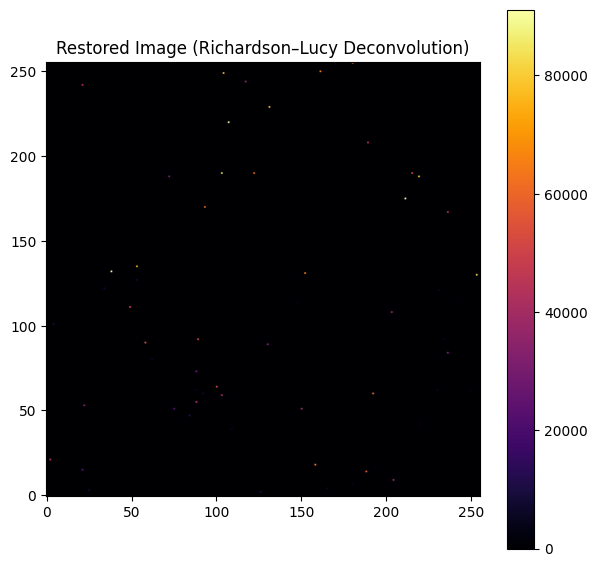

In [13]:
import numpy as np
from scipy.signal import fftconvolve
import matplotlib.pyplot as plt

# Inputs from previous module:
# combined_image  -> your final blurred noisy image
# combined_psf    -> PSF including aberrations + turbulence

# Normalize PSF
psf_norm = combined_psf / np.sum(combined_psf)

# Richardson–Lucy deconvolution function
def richardson_lucy(image, psf, iterations=20):
    image = image.astype(float)
    psf_mirror = psf[::-1, ::-1]
    estimate = np.full(image.shape, 0.5)

    for i in range(iterations):
        relative_blur = image / (fftconvolve(estimate, psf, mode='same') + 1e-7)
        estimate *= fftconvolve(relative_blur, psf_mirror, mode='same')
    return estimate

# Run RL deconvolution
restored_rl = richardson_lucy(combined_image, psf_norm, iterations=20)

plt.figure(figsize=(7,7))
plt.imshow(restored_rl, cmap='inferno', origin='lower')
plt.colorbar()
plt.title("Restored Image (Richardson–Lucy Deconvolution)")
plt.show()


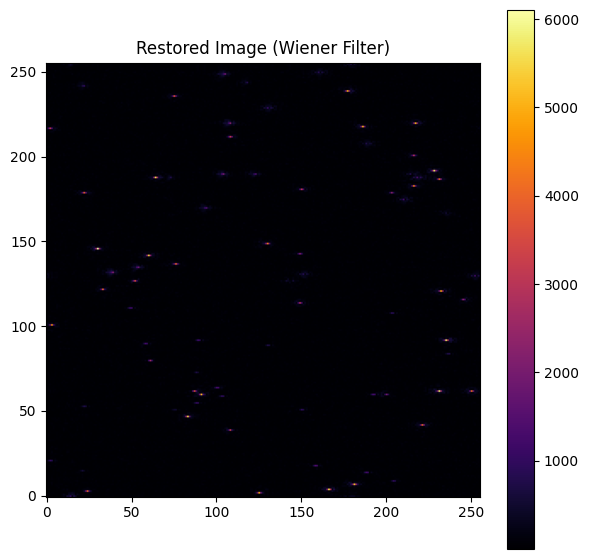

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift

# Inputs (you already have these):
# combined_image  -> final blurred noisy image
# combined_psf    -> final PSF (aberrations + turbulence)

# --- 1. Normalize PSF ---
psf_norm = combined_psf / np.sum(combined_psf)

# --- 2. Compute FFT of image and PSF ---
G = fft2(combined_image)
H = fft2(psf_norm, s=combined_image.shape)

# --- 3. Wiener filter ---
K = 0.001   # noise constant (you can tune this later)

H_conj = np.conj(H)
wiener_filter = H_conj / (np.abs(H)**2 + K)

F_hat = G * wiener_filter
restored_wiener = np.abs(ifft2(F_hat))

# --- 4. Plot result ---
plt.figure(figsize=(7,7))
plt.imshow(restored_wiener, cmap='inferno', origin='lower')
plt.colorbar()
plt.title("Restored Image (Wiener Filter)")
plt.show()


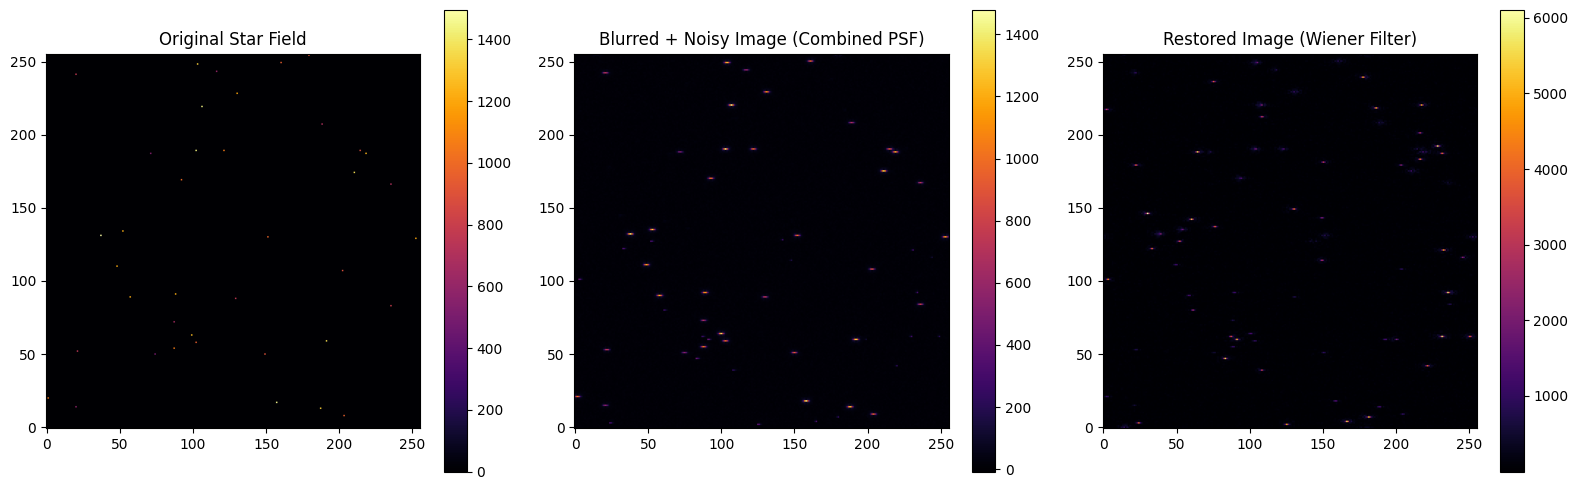

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,5))

# 1 — Original star field
plt.subplot(1,3,1)
plt.imshow(star_field, cmap='inferno', origin='lower')
plt.title("Original Star Field")
plt.colorbar()

# 2 — Blurred + noisy image
plt.subplot(1,3,2)
plt.imshow(combined_image, cmap='inferno', origin='lower')
plt.title("Blurred + Noisy Image (Combined PSF)")
plt.colorbar()

# 3 — Restored image (choose Wiener / RL)
plt.subplot(1,3,3)
plt.imshow(restored_wiener, cmap='inferno', origin='lower')
plt.title("Restored Image (Wiener Filter)")
plt.colorbar()

plt.tight_layout()
plt.show()

In [16]:
import numpy as np

def compute_strehl(psf, psf_ideal):
    peak_real  = np.max(psf)
    peak_ideal = np.max(psf_ideal)
    return peak_real / (peak_ideal + 1e-12)

strehl_value = compute_strehl(combined_psf, psf_ideal)
print("Strehl Ratio:", strehl_value)

Strehl Ratio: 0.9999999999989999


In [17]:
# ---------------------------
# Advanced: Zernike-like aberrations + atmosphere -> PSF + Strehl
# ---------------------------
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, fftshift
from scipy.signal import fftconvolve
from astropy.io import fits

# ---------- Parameters ----------
N = 256
wavelength = 550e-9
phase_scale_atm = 0.5
r0 = 0.10
L0 = 10.0

# Zernike coefficients (waves)
coeff_defocus   = 0.05
coeff_astig     = 0.03
coeff_coma      = 0.02
coeff_trefoil   = 0.01
coeff_spherical = 0.04

# ---------- Pupil coordinates ----------
x = np.linspace(-1, 1, N)
X, Y = np.meshgrid(x, x)
R = np.sqrt(X**2 + Y**2)
pupil = (R <= 1).astype(float)
theta = np.arctan2(Y, X)
rho = np.where(R==0, 0, R)

# ---------- Zernike-like modes ----------
Z_defocus   = 2*(rho**2) - 1.0
Z_astig_cos = rho**2 * np.cos(2*theta)
Z_coma_x    = (3*rho**3 - 2*rho) * np.cos(theta)
Z_trefoil   = rho**3 * np.cos(3*theta)
Z_spherical = 6*rho**4 - 6*rho**2 + 1

# mask outside pupil
Z_defocus   *= pupil
Z_astig_cos *= pupil
Z_coma_x    *= pupil
Z_trefoil   *= pupil
Z_spherical *= pupil

# ---------- Total Zernike wavefront ----------
W_zernike = (coeff_defocus * Z_defocus +
             coeff_astig * Z_astig_cos +
             coeff_coma * Z_coma_x +
             coeff_trefoil * Z_trefoil +
             coeff_spherical * Z_spherical)

phi_zernike = 2 * np.pi * W_zernike  # radians

# ---------- Atmospheric phase ----------
def make_phase_screen(N=N, r0=r0, L0=L0):
    fx = np.fft.fftfreq(N, d=1.0/N)
    FX, FY = np.meshgrid(fx, fx)
    f = np.sqrt(FX**2 + FY**2)
    f[0,0] = 1e-6
    P = (f**2 + (1.0/L0)**2)**(-11/6)
    cn = np.random.normal(size=(N,N)) + 1j*np.random.normal(size=(N,N))
    fourier = cn * np.sqrt(P)
    phase = np.fft.ifft2(np.fft.ifftshift(fourier)).real
    phase = (phase - phase.mean()) / (phase.std() + 1e-12)
    return phase

phase_atm_raw = make_phase_screen()
phi_atm = phase_scale_atm * phase_atm_raw * pupil

# ---------- Total phase ----------
phi_total = (phi_zernike + phi_atm) * pupil

# ---------- Complex pupils ----------
pupil_ideal = pupil
pupil_zern  = pupil * np.exp(1j * phi_zernike)
pupil_atm   = pupil * np.exp(1j * phi_atm)
pupil_comb  = pupil * np.exp(1j * phi_total)

# ---------- PSF function ----------
def psf_from_pupil(cpupil):
    amp = fftshift(fft2(cpupil))
    I = np.abs(amp)**2
    I /= I.max() + 1e-16
    return I

psf_ideal   = psf_from_pupil(pupil_ideal)
psf_zern    = psf_from_pupil(pupil_zern)
psf_atm     = psf_from_pupil(pupil_atm)
psf_comb    = psf_from_pupil(pupil_comb)

# ---------- Strehl ratios ----------
strehl_z   = np.max(psf_zern)  / np.max(psf_ideal)
strehl_a   = np.max(psf_atm)   / np.max(psf_ideal)
strehl_c   = np.max(psf_comb)  / np.max(psf_ideal)

print("Strehl (Zernike):", strehl_z)
print("Strehl (Atmosphere):", strehl_a)
print("Strehl (Combined):", strehl_c)


Strehl (Zernike): 1.0
Strehl (Atmosphere): 1.0
Strehl (Combined): 1.0


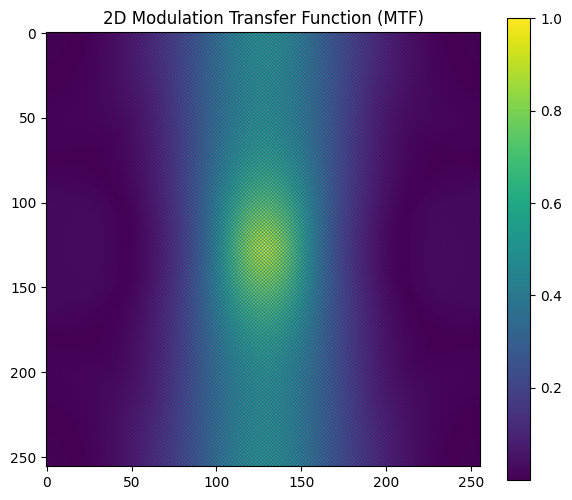

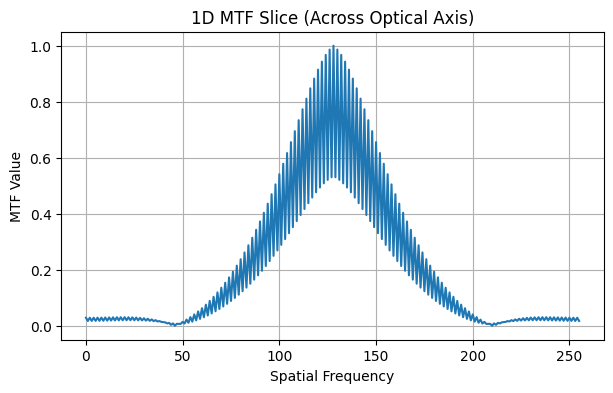

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Use your combined PSF from earlier
psf = combined_psf  # if your variable is different, update this line

# Compute OTF using FFT of PSF
otf = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(psf)))

# MTF = magnitude of OTF
mtf = np.abs(otf)

# Normalize
mtf /= np.max(mtf)

# Plot MTF 2D
plt.figure(figsize=(7,6))
plt.imshow(mtf, cmap='viridis')
plt.title("2D Modulation Transfer Function (MTF)")
plt.colorbar()
plt.show()

# Plot MTF 1D radial slice
center = mtf.shape[0] // 2
mtf_1d = mtf[center, :]

plt.figure(figsize=(7,4))
plt.plot(mtf_1d)
plt.title("1D MTF Slice (Across Optical Axis)")
plt.xlabel("Spatial Frequency")
plt.ylabel("MTF Value")
plt.grid(True)
plt.show()


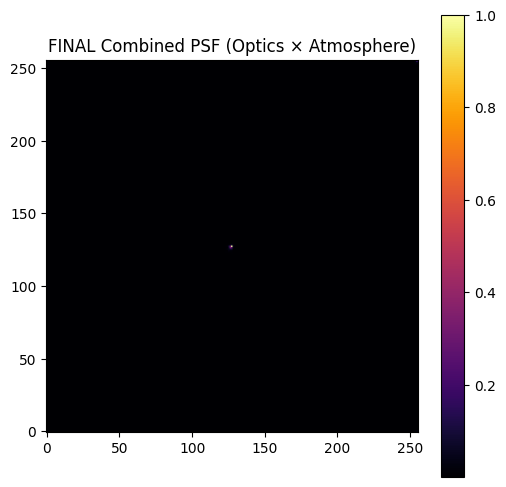

Correct Final Strehl Ratio: 1.0
Saved final_combined_psf.fits successfully!


In [20]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift

# ------------------------------
# Load PSFs saved from earlier
# ------------------------------
psf_optics = fits.getdata("psf_zernike.fits")        # From 03-aberrations
psf_long   = fits.getdata("psf_atm_long.fits")       # From 04-atmosphere

# ------------------------------
# Resize to match
# ------------------------------
min_size = min(psf_optics.shape[0], psf_long.shape[0])
psf_optics = psf_optics[:min_size, :min_size]
psf_long   = psf_long[:min_size, :min_size]

# ------------------------------
# Combine using OTF multiplication
# ------------------------------
otf_optics = fft2(fftshift(psf_optics))
otf_atmos  = fft2(fftshift(psf_long))

otf_combined = otf_optics * otf_atmos
psf_combined = np.abs(fftshift(ifft2(otf_combined)))
psf_combined /= psf_combined.max()

# ------------------------------
# Plot
# ------------------------------
plt.figure(figsize=(6,6))
plt.imshow(psf_combined, cmap='inferno', origin='lower')
plt.colorbar()
plt.title("FINAL Combined PSF (Optics × Atmosphere)")
plt.show()

# ------------------------------
# Compute Strehl
# ------------------------------
strehl_ratio = psf_combined.max() / psf_optics.max()
print("Correct Final Strehl Ratio:", strehl_ratio)

# ------------------------------
# SAVE FINAL PSF
# ------------------------------
from astropy.io import fits
fits.writeto("final_combined_psf.fits", psf_combined.astype(np.float32), overwrite=True)
print("Saved final_combined_psf.fits successfully!")